In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Read in the event log
log = pd.read_csv('data/Dhana Loans 2023.csv',sep=',')

In [3]:
# Convert timestamps to pandas datetime
log['start_time'] = pd.to_datetime(log['start_time'], infer_datetime_format=True)
log['end_time'] = pd.to_datetime(log['end_time'], infer_datetime_format=True)

In [4]:
log['num_offers'] = log.groupby('Loan ID')['OfferID'].transform('nunique')

In [5]:
# Add the final state as outcome
last_application_state = log[log.EventOrigin == "Application"].sort_values('start_time', ascending=True, kind='mergesort').groupby("Loan ID").last()["Activity"]
last_application_state = pd.DataFrame(last_application_state)
last_application_state.columns = ["outcome"]

di = {'A_Pending': "Pending", 'A_Cancelled': "Cancelled", 'A_Denied':'Denied'}
last_application_state.replace({"outcome": di})

log = log.merge(last_application_state, left_on="Loan ID", right_index=True)

In [34]:
log['CreditScore_imputed'] = log.groupby('Loan ID')['CreditScore'].transform(lambda grp: grp.fillna(method='ffill'))
log['CreditScore_imputed'] = log.groupby('Loan ID')['CreditScore_imputed'].transform(lambda grp: grp.fillna(method='bfill'))

In [35]:
last_events = log.groupby('Loan ID').last().reset_index()

In [57]:
last_events.columns

Index(['Loan ID', 'start_time', 'end_time', 'ApplicationType', 'LoanGoal',
       'RequestedAmount', 'Accepted', 'Action', 'CreditScore', 'EventID',
       'EventOrigin', 'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms',
       'OfferID', 'OfferedAmount', 'Selected', 'Activity', 'Resource',
       'num_offers', 'outcome', 'CreditScore_imputed'],
      dtype='object')

In [38]:
last_events.CreditScore_imputed.isna().sum()

0

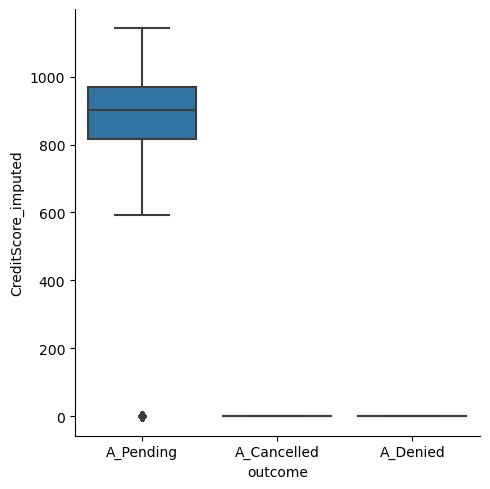

In [37]:
import matplotlib.pyplot as plt
sns.catplot(data=last_events, x="outcome", y="CreditScore_imputed", kind="box")
plt.show()

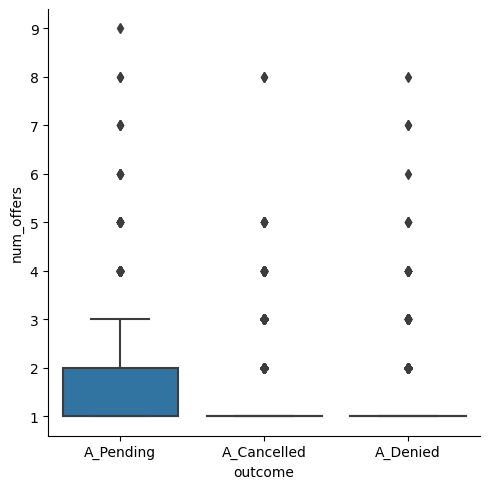

In [42]:
import matplotlib.pyplot as plt
sns.catplot(data=last_events, x="outcome", y="num_offers", kind="box")
plt.show()

In [43]:
offered_amount_notnull = log[~log.OfferedAmount.isna()]
offered_amount_notnull['off_am<req_am'] = (offered_amount_notnull.OfferedAmount < offered_amount_notnull.RequestedAmount)

C:\Users\kohvk\AppData\Local\Temp\ipykernel_9404\3699564928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offered_amount_notnull['off_am<req_am'] = (offered_amount_notnull.OfferedAmount < offered_amount_notnull.RequestedAmount)


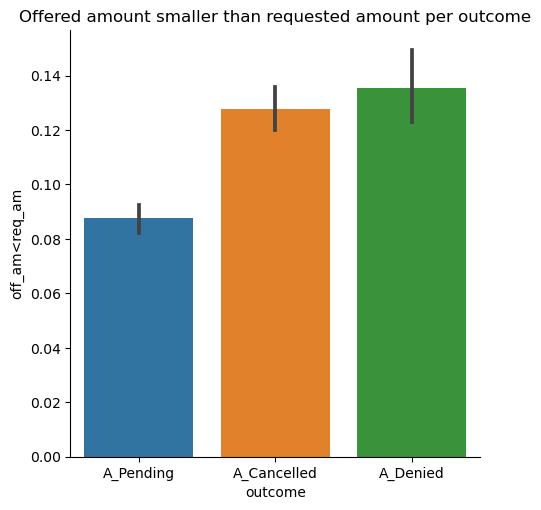

In [51]:
import matplotlib.pyplot as plt
sns.catplot(data=offered_amount_notnull.groupby('Loan ID').last(), y="off_am<req_am", x="outcome",kind='bar').set(title='Offered amount smaller than requested amount per outcome')
plt.show()